In [83]:
import collections
import glob
import json
import os

import numpy as np
import pandas as pd
import pickle
from plotnine import *
import sklearn.metrics
from sklearn.decomposition import PCA
import umap

In [84]:
data_dir = '../../data'
metadata_path = os.path.join(data_dir, 'recount_metadata.tsv')
metadata_df = pd.read_csv(metadata_path, sep='\t')
metadata_df = metadata_df.drop_duplicates()

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3170: DtypeWarning: Columns (11,14,21,22,25,26,29,30,35,36,39,40,41,158,159,166,167,169,170) have mixed types.Specify dtype option on import or set low_memory=False.


In [85]:
metadata_df

,rail_id,external_id,study,sra.sample_acc.x,sra.experiment_acc,sra.submission_acc,sra.submission_center,sra.submission_lab,sra.study_title,sra.study_abstract,...,recount_seq_qc.%n,recount_seq_qc.avgq,recount_seq_qc.errq,recount_pred.sample_acc.y,recount_pred.curated.type,recount_pred.curated.tissue,recount_pred.pattern.predict.type,recount_pred.pred.type,recount_pred.curated.cell_type,recount_pred.curated.cell_line
1,1007887.0,SRR7252610,SRP149665,SRS3369783,SRX4157332,SRA714700,GEO,NaN,Virus Infection Induces Expression of Novel RN...,Innate antiviral immune responses are driven b...,...,0.0,35.8,21.8,SRS3369783,NaN,NaN,rna-seq,rna-seq,NaN,NaN
2,1007903.0,SRR7252611,SRP149665,SRS3369784,SRX4157333,SRA714700,GEO,NaN,Virus Infection Induces Expression of Novel RN...,Innate antiviral immune responses are driven b...,...,0.0,35.3,21,SRS3369784,NaN,NaN,rna-seq,rna-seq,NaN,NaN
3,1007918.0,SRR7252612,SRP149665,SRS3369785,SRX4157334,SRA714700,GEO,NaN,Virus Infection Induces Expression of Novel RN...,Innate antiviral immune responses are driven b...,...,0.0,35.3,21.1,SRS3369785,NaN,NaN,rna-seq,rna-seq,NaN,NaN
4,2015537.0,SRR7252609,SRP149665,SRS3369782,SRX4157331,SRA714700,GEO,NaN,Virus Infection Induces Expression of Novel RN...,Innate antiviral immune responses are driven b...,...,0.0,35.7,21.6,SRS3369782,NaN,NaN,rna-seq,rna-seq,NaN,NaN
5,1004924.0,SRR629557,SRP017465,SRS378921,SRX209056,SRA062599,Human Protein Atlas,Science for Life Lab,RNA sequencing results,RNA sequencing data for human cell lines.,...,0.0,32.8,15.4,SRS378921,NaN,NaN,rna-seq,rna-seq,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
341146,NaN,NaN,SRP106855,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
341147,NaN,NaN,SRP103855,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
341148,NaN,NaN,SRP092128,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
341149,NaN,NaN,DRP003828,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [86]:
sample_to_study = dict(zip(metadata_df['external_id'], metadata_df['study']))

In [87]:
label_file = os.path.join(data_dir, 'recount_sample_to_label.pkl')
with open(label_file, 'rb') as in_file:
    sample_to_label = pickle.load(in_file)

In [88]:
metadata_df['label'] = metadata_df['external_id'].map(sample_to_label)

## Load the results from a sample-split experiment

In [89]:
in_files = glob.glob('../../results/sample-split.*.tsv')
print(in_files[:5])

['../../results/sample-split.deep_net_2.tsv', '../../results/sample-split.pytorch_lr_0.tsv', '../../results/sample-split.pytorch_lr_2.tsv', '../../results/sample-split.deep_net_1.tsv', '../../results/sample-split.pytorch_supervised_0.tsv']


In [90]:
tissue_metrics = pd.DataFrame()

for path in in_files:
    new_df = pd.read_csv(path, sep='\t')
    model_info = path.strip('.tsv').split('biobert.')[-1]
    model_info = model_info.split('.')
    model_info = model_info[-1]
    model_info = model_info.split('_')
        
    supervised_model = '_'.join(model_info[:2])
             
    new_df['supervised'] = supervised_model
    
    new_df['seed'] = model_info[-1]
            
    tissue_metrics = pd.concat([tissue_metrics, new_df])
    
tissue_metrics['train_count'] = tissue_metrics['train sample count']
tissue_metrics['supervised'] = tissue_metrics['supervised'].str.replace('pytorch_supervised', 'three_layer_net')

tissue_metrics

,accuracy,balanced_accuracy,train studies,train samples,val samples,train sample count,fraction of data used,is_pretrained,val_predictions,val_true_labels,val_encoders,supervised,seed,train_count
0,0.699664,0.681051,"SRP020491,SRP010644,SRP014620,SRP033131,SRP062...","SRR1012930,SRR364681,SRR925720,DRR006405,SRR24...","ERR356365,SRR031873,ERR789394,SRR1608655,SRR10...",476,0.1,pretrained,"0,0,0,2,9,5,17,6,16,13,12,0,16,14,9,0,0,0,10,4...","0,0,0,0,9,6,17,6,17,14,12,0,16,14,9,0,0,0,0,15...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",deep_net,2,476
1,0.057466,0.106381,"SRP020491,SRP010644,SRP014620,SRP033131,SRP062...","SRR1012930,SRR364681,SRR925720,DRR006405,SRR24...","ERR356365,SRR031873,ERR789394,SRR1608655,SRR10...",476,0.1,not_pretrained,"14,13,19,13,18,13,16,19,14,13,19,18,2,14,14,2,...","0,0,0,0,9,6,17,6,17,14,12,0,16,14,9,0,0,0,0,15...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",deep_net,2,476
2,0.783138,0.747850,"SRP020491,SRP010644,SRP014620,SRP033250,SRP033...","SRR1012930,SRR364681,SRR925720,DRR006405,SRR24...","ERR356365,SRR031873,ERR789394,SRR1608655,SRR10...",953,0.2,pretrained,"0,0,0,2,9,5,17,6,11,14,12,0,16,14,9,0,0,0,10,4...","0,0,0,0,9,6,17,6,17,14,12,0,16,14,9,0,0,0,0,15...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",deep_net,2,953
3,0.118289,0.167478,"SRP020491,SRP010644,SRP014620,SRP033250,SRP033...","SRR1012930,SRR364681,SRR925720,DRR006405,SRR24...","ERR356365,SRR031873,ERR789394,SRR1608655,SRR10...",953,0.2,not_pretrained,"18,18,0,18,18,5,16,18,18,19,19,18,16,14,16,13,...","0,0,0,0,9,6,17,6,17,14,12,0,16,14,9,0,0,0,0,15...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",deep_net,2,953
4,0.809564,0.730008,"SRP033250,SRP033131,SRP035670,SRP012585,SRP010...","SRR1012930,SRR364681,SRR925720,DRR006405,SRR24...","ERR356365,SRR031873,ERR789394,SRR1608655,SRR10...",1429,0.3,pretrained,"0,0,0,0,9,5,17,6,11,14,12,0,16,14,9,0,0,0,10,4...","0,0,0,0,9,6,17,6,17,14,12,0,16,14,9,0,0,0,0,15...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",deep_net,2,1429
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.698279,0.381835,"SRP008746,SRP031858,SRP035665,SRP014620,SRP014...","SRR2049710,SRR1015696,SRR189776,SRR830954,ERR3...","SRR1551001,SRR1377150,SRR1036101,SRR1283008,SR...",3813,0.8,not_pretrained,"0,12,0,11,17,0,4,0,4,4,3,0,12,11,11,0,3,17,4,0...","0,12,0,20,0,0,3,0,14,7,3,0,12,14,17,16,3,4,4,0...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",three_layer_net,1,3813
96,0.845573,0.691437,"SRP008746,SRP031858,SRP035665,SRP014620,SRP014...","SRR2049710,SRR1015696,SRR189776,SRR830954,ERR3...","SRR1551001,SRR1377150,SRR1036101,SRR1283008,SR...",4290,0.9,pretrained,"0,12,0,11,17,0,17,0,4,7,3,0,12,4,20,16,3,4,4,0...","0,12,0,20,0,0,3,0,14,7,3,0,12,14,17,16,3,4,4,0...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",three_layer_net,1,4290
97,0.755770,0.584164,"SRP008746,SRP031858,SRP035665,SRP014620,SRP014...","SRR2049710,SRR1015696,SRR189776,SRR830954,ERR3...","SRR1551001,SRR1377150,SRR1036101,SRR1283008,SR...",4290,0.9,not_pretrained,"0,12,0,11,17,0,3,0,4,7,3,0,12,4,4,16,3,4,4,19,...","0,12,0,20,0,0,3,0,14,7,3,0,12,14,17,16,3,4,4,0...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",three_layer_net,1,4290
98,0.834662,0.687025,"DRP001219,SRP008746,SRP031858,SRP035665,SRP014...","SRR2049710,SRR1015696,SRR189776,SRR830954,ERR3...","SRR1551001,SRR1377150,SRR1036101,SRR1283008,SR...",4767,1.0,pretrained,"0,12,0,11,17,0,4,0,4,7,3,0,12,4,20,16,3,4,4,19...","0,12,0,20,0,0,3,0,14,7,3,0,12,14,17,16,3,4,4,0...","{""Blood"": 0, ""Blood Vessel"": 1, ""Bone Marrow"":...",three_layer_net,1,4767


In [91]:
sample_model_predictions = {}
model_predictions = {}
# Process dataframe rows
for i, row in tissue_metrics[tissue_metrics['is_pretrained'] == 'not_pretrained'].iterrows():
    model = row['supervised']
    
    if model not in model_predictions:
        model_predictions[model] = {'predicted': [], 'true': []}
    
    encoder_string = row['val_encoders']
    encoder = json.loads(encoder_string)
    decoder = {number: label for label, number in encoder.items()}
    
    samples = row['val samples'].strip().split(',')
    
    predictions = row['val_predictions'].strip().split(',')
    truth = row['val_true_labels'].strip().split(',')
    pred_labels = []
    
    for prediction in predictions:
        if int(prediction) in decoder:
            pred_labels.append(decoder[int(prediction)])
        else:
            # https://github.com/greenelab/saged/issues/58
            pred_labels.append('invalid_index')
            
    predictions = pred_labels
    
    truth = [decoder[int(t)] for t in truth]
    
    assert len(truth) == len(predictions)
    
    model_predictions[model]['predicted'].extend(predictions)
    model_predictions[model]['true'].extend(truth)
    
    for sample, prediction, true_label in zip(samples, predictions, truth):
        if sample not in sample_model_predictions:
            sample_model_predictions[sample] = {}
        if model not in sample_model_predictions[sample]:
            sample_model_predictions[sample][model] = {'correct': 0, 'total': 0, 
                                                       'predictions': [], 'true_label': true_label}
        
        assert sample_model_predictions[sample][model]['true_label'] == true_label
        
        sample_model_predictions[sample][model]['predictions'].append(prediction)
        sample_model_predictions[sample][model]['total'] += 1
        
        correct = (prediction == true_label)
        if correct:
            sample_model_predictions[sample][model]['correct'] += 1

In [92]:
def row_norm(row):
    new_row = row / row.sum()
    return new_row

def create_confusion_df(model_predictions, norm=True):
    predicted = model_predictions['deep_net']['predicted']
    true = model_predictions['deep_net']['true']

    confusion_matrix = sklearn.metrics.confusion_matrix(true, predicted, labels=list(encoder.keys()))

    
    if norm:
        confusion_matrix = np.apply_along_axis(row_norm, axis=1, arr=confusion_matrix)
    confusion_df = pd.DataFrame(confusion_matrix, index = [l for l in encoder.keys()],
                                columns = [l for l in encoder.keys()])
    
    confusion_df['true_tissue'] = confusion_df.index
    confusion_df = confusion_df.dropna()
    return confusion_df

In [93]:
confusion_df = create_confusion_df(model_predictions, norm=False)

In [94]:
melted_df = confusion_df.melt(id_vars='true_tissue', var_name='pred_tissue')
melted_df['log_value'] = np.log(melted_df['value'])

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log


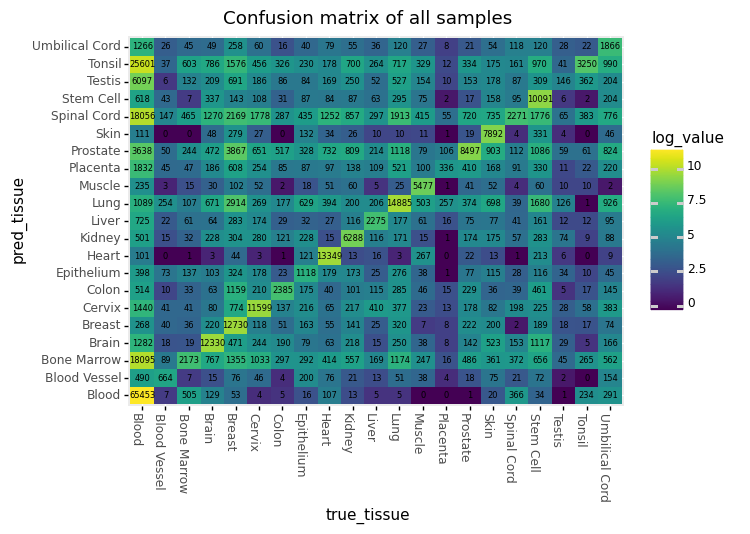

<ggplot: (8746082041801)>

In [95]:
plot = ggplot(melted_df, aes(x='true_tissue', y='pred_tissue', fill='log_value',)) 
plot += geom_tile() 
plot += geom_text(aes(label='value'), size=6)
plot += theme(axis_text_x=element_text(rotation=270, hjust=1))
plot += ggtitle('Confusion matrix of all samples')
plot

In [96]:
confusion_df = create_confusion_df(model_predictions, norm=True)

In [97]:
melted_df = confusion_df.melt(id_vars='true_tissue', var_name='pred_tissue')
melted_df['log_value'] = np.log(melted_df['value'])
melted_df['percent'] = (melted_df['value'] * 100).round(1)

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log


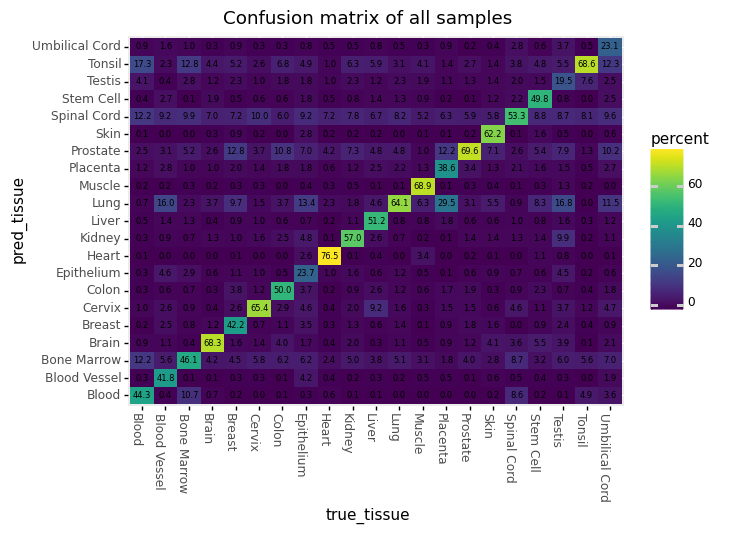

<ggplot: (8746093476841)>

In [98]:
plot = ggplot(melted_df, aes(x='true_tissue', y='pred_tissue', fill='percent',)) 
plot += geom_tile() 
plot += geom_text(aes(label='percent'), size=6)
plot += theme(axis_text_x=element_text(rotation=270, hjust=1))
plot += ggtitle('Confusion matrix of all samples')
plot

In [99]:
data_dict_list = []

for sample in sample_model_predictions:
    data_dict = {}
    data_dict['sample'] = sample
    for model in sample_model_predictions[sample]:
        total = sample_model_predictions[sample][model]['total']
        correct = sample_model_predictions[sample][model]['correct']
        acc = correct / total
        percent_wrong = 100 * (1 - acc)
        
        data_dict['{}_total'.format(model)] =  total 
        data_dict['{}_correct'.format(model)] = correct
        data_dict['{}_acc'.format(model)] = acc
        data_dict['{}_percent_wrong'.format(model)] = percent_wrong
    data_dict_list.append(data_dict)
        
acc_df = pd.DataFrame(data_dict_list)

In [100]:
acc_df

,sample,deep_net_total,deep_net_correct,deep_net_acc,deep_net_percent_wrong,pytorch_lr_total,pytorch_lr_correct,pytorch_lr_acc,pytorch_lr_percent_wrong,three_layer_net_total,three_layer_net_correct,three_layer_net_acc,three_layer_net_percent_wrong,logistic_regression_total,logistic_regression_correct,logistic_regression_acc,logistic_regression_percent_wrong
0,ERR356365,30,8,0.266667,73.333333,30,13,0.433333,56.666667,30,20,0.666667,33.333333,30,30,1.0,0.0
1,SRR031873,30,9,0.300000,70.000000,30,21,0.700000,30.000000,30,18,0.600000,40.000000,30,30,1.0,0.0
2,ERR789394,30,22,0.733333,26.666667,30,30,1.000000,0.000000,30,29,0.966667,3.333333,30,30,1.0,0.0
3,SRR1608655,30,13,0.433333,56.666667,30,27,0.900000,10.000000,30,28,0.933333,6.666667,30,30,1.0,0.0
4,SRR1038623,30,22,0.733333,26.666667,30,25,0.833333,16.666667,30,18,0.600000,40.000000,30,30,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11913,SRR1035698,30,14,0.466667,53.333333,30,27,0.900000,10.000000,30,23,0.766667,23.333333,30,30,1.0,0.0
11914,SRR857238,30,0,0.000000,100.000000,30,1,0.033333,96.666667,30,3,0.100000,90.000000,30,0,0.0,100.0
11915,SRR1054290,30,25,0.833333,16.666667,30,25,0.833333,16.666667,30,16,0.533333,46.666667,30,30,1.0,0.0
11916,SRR1027468,30,0,0.000000,100.000000,30,3,0.100000,90.000000,30,1,0.033333,96.666667,30,0,0.0,100.0


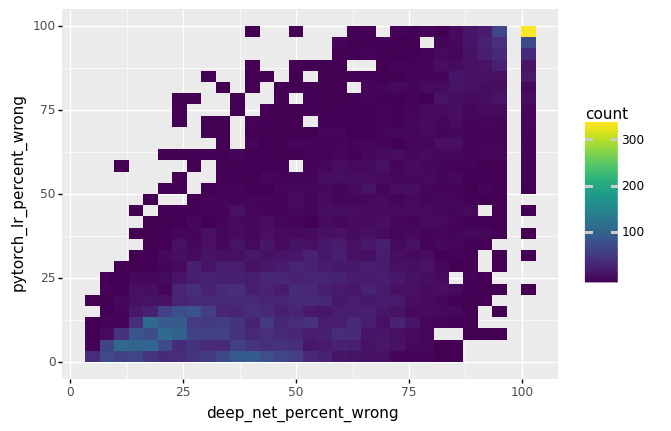

<ggplot: (8746093476637)>

In [101]:
plot = ggplot(acc_df, aes(x='deep_net_percent_wrong', y='pytorch_lr_percent_wrong'))
plot += geom_bin2d()
plot

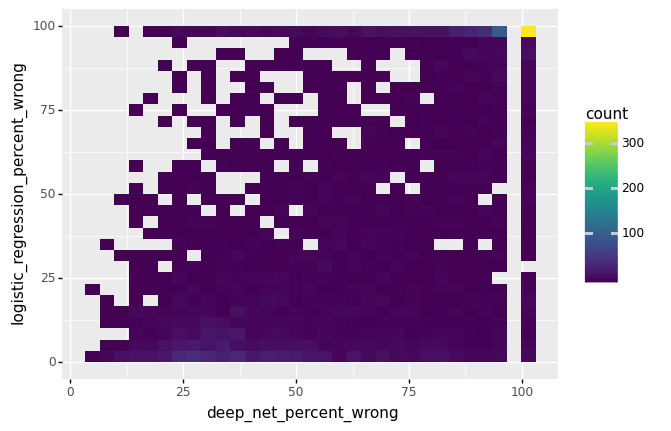

<ggplot: (8746093476629)>

In [102]:
plot = ggplot(acc_df, aes(x='deep_net_percent_wrong', y='logistic_regression_percent_wrong'))
plot += geom_bin2d()
plot

## What do the individual distributions look like?

<AxesSubplot:ylabel='Frequency'>

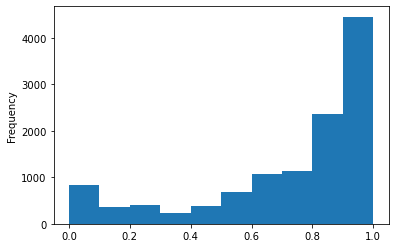

In [103]:
acc_df['pytorch_lr_acc'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

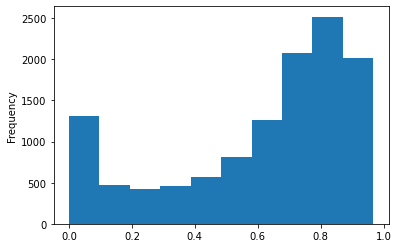

In [104]:
acc_df['three_layer_net_acc'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

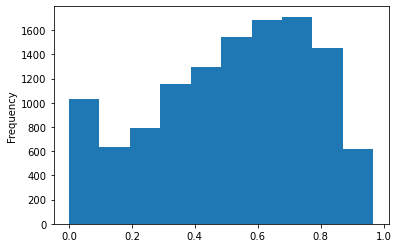

In [105]:
acc_df['deep_net_acc'].plot.hist()

<AxesSubplot:ylabel='Frequency'>

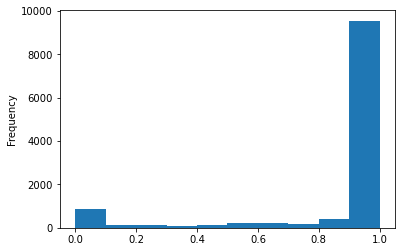

In [106]:
acc_df['logistic_regression_acc'].plot.hist()

### Results
The pytorch models have more variation than the sklearn LR model. In general, there do seem to be some samples that are harder to classify. Is this a quirk of the dataset, or something that happens across datasets?

## Look at samples misclassified by all models in every case

In [107]:
hard_samples = []
for sample in sample_model_predictions:
    good_prediction = False
    for model in sample_model_predictions[sample]:
        correct = sample_model_predictions[sample][model]['correct']
        if correct > 0:
            good_prediction = True
    
    if not good_prediction:
        hard_samples.append(sample)

In [108]:
print(len(hard_samples))

studies = set([sample_to_study[sample] for sample in hard_samples])
print(len(studies))

print(studies)

230
92
{'SRP012295', 'SRP022054', 'SRP017942', 'SRP007508', 'SRP031478', 'SRP005281', 'SRP027514', 'SRP017330', 'SRP041820', 'SRP012695', 'SRP021214', 'SRP041263', 'SRP028705', 'SRP016118', 'SRP044668', 'SRP044303', 'SRP015761', 'SRP028822', 'SRP041846', 'SRP013984', 'SRP021916', 'SRP015336', 'SRP017378', 'SRP010678', 'SRP019961', 'SRP021912', 'SRP008746', 'SRP016059', 'SRP029889', 'SRP039591', 'SRP026089', 'SRP034737', 'SRP001349', 'SRP012015', 'SRP007461', 'SRP042184', 'SRP032989', 'SRP023111', 'SRP017843', 'SRP001371', 'SRP029888', 'SRP042153', 'SRP007359', 'SRP033491', 'SRP009386', 'SRP006912', 'SRP038759', 'SRP032775', 'SRP011107', 'SRP003754', 'SRP033078', 'SRP043221', 'SRP032922', 'SRP011895', 'SRP038101', 'SRP021524', 'SRP028336', 'SRP015361', 'SRP005242', 'SRP010907', 'SRP023233', 'SRP014906', 'SRP002079', 'SRP028804', 'SRP028902', 'SRP011085', 'SRP028118', 'SRP009029', 'SRP035641', 'SRP032559', 'SRP026690', 'SRP007412', 'SRP036133', 'SRP010644', 'SRP041988', 'SRP014739', 'SRP

In [109]:
print(hard_samples[:5])

['SRR651674', 'SRR423929', 'SRR306844', 'SRR771240', 'SRR1294120']


### Are all samples in a study with hard samples unclassifiable?

In [110]:
samples_in_bad_studies = 0
for sample, study in sample_to_study.items():
    if study in studies:
        samples_in_bad_studies += 1

print(len(hard_samples), samples_in_bad_studies, len(hard_samples) / samples_in_bad_studies)

230 2038 0.11285574092247301


For each sample that is universally incorrectly classified, there are six other in the same study that are fine

### Are there any hints in the metadata about why the samples are hard to classify?

In [111]:
metadata_df = metadata_df.set_index('external_id')

In [112]:
metadata_df = metadata_df[metadata_df.index.notnull()]

In [113]:
hard_sample_df = metadata_df.loc[hard_samples]
hard_sample_df

,rail_id,study,sra.sample_acc.x,sra.experiment_acc,sra.submission_acc,sra.submission_center,sra.submission_lab,sra.study_title,sra.study_abstract,sra.study_description,...,recount_seq_qc.avgq,recount_seq_qc.errq,recount_pred.sample_acc.y,recount_pred.curated.type,recount_pred.curated.tissue,recount_pred.pattern.predict.type,recount_pred.pred.type,recount_pred.curated.cell_type,recount_pred.curated.cell_line,label
external_id,,,,,,,,,,,,,,,,,,,,,
SRR651674,1494673.0,SRP000941,SRS348369,SRX190116,SRA009129,GEO,NaN,UCSD Human Reference Epigenome Mapping Project,The human embryonic stem cells (hESCs) are a u...,"For data usage terms and conditions, please re...",...,35.3,19.5,SRS348369,rna-seq,Stem Cell,rna-seq,rna-seq,NaN,NaN,Stem Cell
SRR423929,510287.0,SRP011085,SRS295689,SRX124473,SRA050382,UMIGS,Genomics Resource Core,Characterization of transcriptome dynamics in ...,Candida albicans is the major invasive fungal ...,NaN,...,30.3,11.3,SRS295689,NaN,Heart,rna-seq,rna-seq,NaN,NaN,Heart
SRR306844,820300.0,SRP007412,SRS214080,SRX081988,SRA039810,GEO,NaN,The evolution of gene expression levels in mam...,Changes in gene expression are thought to unde...,NaN,...,22.1,16.1,SRS214080,rna-seq,Blood,rna-seq,rna-seq,NaN,NaN,Blood
SRR771240,3182626.0,SRP019222,SRS400402,SRX248288,SRA068903,GEO,NaN,Epstein-Barr virus maintains lymphomas via its...,Epstein-Barr virus (EBV) has evolved exquisite...,NaN,...,38.1,22.5,SRS400402,NaN,Epithelium,rna-seq,scrna-seq,NaN,NaN,Epithelium
SRR1294120,428293.0,SRP042153,SRS616760,SRX548798,SRA166603,GEO,NaN,RNAseq transcriptome data from reprogramming h...,We reprogrammed human CD34+ cells from cord bl...,NaN,...,32.9,13.5,SRS616760,NaN,Blood,rna-seq,rna-seq,NaN,NaN,Blood
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR1030493,1198396.0,SRP033078,SRS502905,SRX378110,SRA111406,GEO,NaN,Human iPSC-based Modeling of Late-Onset Diseas...,Reprogramming somatic cells to induced pluripo...,NaN,...,34.3,14.1,SRS502905,NaN,Breast,rna-seq,rna-seq,NaN,NaN,Breast
SRR770716,2286299.0,SRP019207,SRS400330,SRX248166,SRA068882,GEO,NaN,Breakpoint analysis of transcriptional and gen...,We report the design and implementation of a \...,NaN,...,30,12.4,SRS400330,NaN,Blood,rna-seq,rna-seq,NaN,NaN,Blood
SRR835319,3720800.0,SRP021524,SRS416312,SRX272036,SRA074407,GEO,NaN,Human PA-1 cells treated with scrambled or spe...,"We describe the discovery of sno-lncRNAs, a cl...",NaN,...,35.6,17.5,SRS416312,NaN,Umbilical Cord,rna-seq,rna-seq,NaN,NaN,Umbilical Cord


In [114]:
metadata_df['recount_seq_qc.avgq'] = pd.to_numeric(metadata_df['recount_seq_qc.avgq'], errors='coerce')
metadata_df = metadata_df[metadata_df['recount_seq_qc.avgq'].notnull()]
metadata_df

,rail_id,study,sra.sample_acc.x,sra.experiment_acc,sra.submission_acc,sra.submission_center,sra.submission_lab,sra.study_title,sra.study_abstract,sra.study_description,...,recount_seq_qc.avgq,recount_seq_qc.errq,recount_pred.sample_acc.y,recount_pred.curated.type,recount_pred.curated.tissue,recount_pred.pattern.predict.type,recount_pred.pred.type,recount_pred.curated.cell_type,recount_pred.curated.cell_line,label
external_id,,,,,,,,,,,,,,,,,,,,,
SRR7252610,1007887.0,SRP149665,SRS3369783,SRX4157332,SRA714700,GEO,NaN,Virus Infection Induces Expression of Novel RN...,Innate antiviral immune responses are driven b...,NaN,...,35.8,21.8,SRS3369783,NaN,NaN,rna-seq,rna-seq,NaN,NaN,NaN
SRR7252611,1007903.0,SRP149665,SRS3369784,SRX4157333,SRA714700,GEO,NaN,Virus Infection Induces Expression of Novel RN...,Innate antiviral immune responses are driven b...,NaN,...,35.3,21,SRS3369784,NaN,NaN,rna-seq,rna-seq,NaN,NaN,NaN
SRR7252612,1007918.0,SRP149665,SRS3369785,SRX4157334,SRA714700,GEO,NaN,Virus Infection Induces Expression of Novel RN...,Innate antiviral immune responses are driven b...,NaN,...,35.3,21.1,SRS3369785,NaN,NaN,rna-seq,rna-seq,NaN,NaN,NaN
SRR7252609,2015537.0,SRP149665,SRS3369782,SRX4157331,SRA714700,GEO,NaN,Virus Infection Induces Expression of Novel RN...,Innate antiviral immune responses are driven b...,NaN,...,35.7,21.6,SRS3369782,NaN,NaN,rna-seq,rna-seq,NaN,NaN,NaN
SRR629557,1004924.0,SRP017465,SRS378921,SRX209056,SRA062599,Human Protein Atlas,Science for Life Lab,RNA sequencing results,RNA sequencing data for human cell lines.,NaN,...,32.8,15.4,SRS378921,NaN,NaN,rna-seq,rna-seq,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR7516583,4808929.0,SRP153228,SRS3542937,SRX4386623,SRA738704,GEO,NaN,lncRNA expression analysis in patients with eo...,Long non-coding RNA (lncRNA) are known to be i...,NaN,...,39.2,28.8,SRS3542937,NaN,NaN,rna-seq,scrna-seq,NaN,NaN,NaN
SRR7516584,4808992.0,SRP153228,SRS3542950,SRX4386624,SRA738704,GEO,NaN,lncRNA expression analysis in patients with eo...,Long non-coding RNA (lncRNA) are known to be i...,NaN,...,38.6,27.6,SRS3542950,NaN,NaN,rna-seq,scrna-seq,NaN,NaN,NaN
SRR7516586,4809120.0,SRP153228,SRS3542952,SRX4386626,SRA738704,GEO,NaN,lncRNA expression analysis in patients with eo...,Long non-coding RNA (lncRNA) are known to be i...,NaN,...,39.0,27.9,SRS3542952,NaN,NaN,rna-seq,scrna-seq,NaN,NaN,NaN


<AxesSubplot:title={'center':'AvgQ Distributon'}, ylabel='Frequency'>

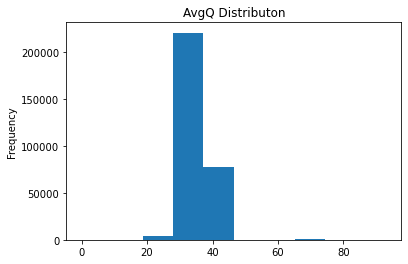

In [115]:
metadata_df['recount_seq_qc.avgq'] = metadata_df['recount_seq_qc.avgq'].astype(float)
metadata_df['recount_seq_qc.avgq'].plot.hist(title='AvgQ Distributon')

<AxesSubplot:title={'center':'AvgQ Distributon in Hard Samples'}, ylabel='Frequency'>

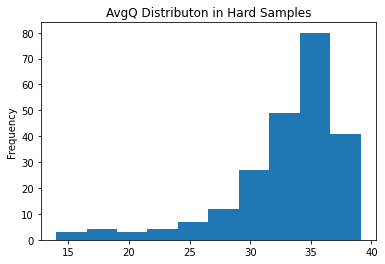

In [116]:
hard_sample_df['recount_seq_qc.avgq'] = hard_sample_df['recount_seq_qc.avgq'].astype(float)
hard_sample_df['recount_seq_qc.avgq'].plot.hist(title='AvgQ Distributon in Hard Samples')

## Do the hard samples stand out in a UMAP embedding?

In [117]:
expression_df = pd.read_pickle("../../data/no_scrna_tpm.pkl")

In [118]:
# Running UMAP on 200k samples just makes a giant oval
is_hard = [sample in hard_samples for sample in expression_df.index]
expression_df['is_hard'] = is_hard

easy_df = expression_df[expression_df['is_hard'] == False]
easy_df = easy_df.sample(n=4000, random_state=42)
hard_df = expression_df[expression_df['is_hard']]
sampled_df = pd.concat([easy_df, hard_df])

# Remove column to extract expression for UMAP
is_hard = sampled_df['is_hard']
sampled_df = sampled_df.drop(['is_hard'], axis='columns')

sampled_df

,ENSG00000253132.1,ENSG00000172465.13,ENSG00000206013.2,ENSG00000214866.8,ENSG00000270390.1,ENSG00000235447.2,ENSG00000108602.17,ENSG00000279997.1,ENSG00000267112.1,ENSG00000234670.1,...,ENSG00000242960.1,ENSG00000274029.1,ENSG00000201945.1,ENSG00000121440.14,ENSG00000229616.2,ENSG00000088992.17,ENSG00000240964.3,ENSG00000111906.17,ENSG00000128596.16,ENSG00000255575.1
sample,,,,,,,,,,,,,,,,,,,,,
SRR6254621,0.0,0.0,0.008499,0.003820,0.005085,0.000000,0.000000,0.011635,0.001536,0.000656,...,0.004890,0.000000e+00,0.034088,0.000138,0.000000,0.044373,0.000000,0.017334,0.003847,0.0
SRR5656303,0.0,0.0,0.018463,0.028015,0.022522,0.000000,0.000000,0.015503,0.000855,0.001897,...,0.000173,0.000000e+00,0.108887,0.000000,0.000000,0.038422,0.000000,0.001931,0.006329,0.0
DRR023496,0.0,0.0,0.011963,0.000783,0.001798,0.000000,0.000000,0.017319,0.000931,0.000556,...,0.042450,0.000000e+00,0.076538,0.000000,0.004414,0.084229,0.000000,0.001129,0.003012,0.0
SRR4437414,0.0,0.0,0.029236,0.031677,0.000479,0.000104,0.000000,0.003170,0.001051,0.000955,...,0.000289,0.000000e+00,0.092834,0.000000,0.000141,0.046600,0.000000,0.001713,0.024216,0.0
SRR3353401,0.0,0.0,0.003376,0.000000,0.004555,0.000207,0.000000,0.033447,0.008942,0.015053,...,0.000193,0.000000e+00,0.083618,0.000741,0.000014,0.056885,0.000000,0.004215,0.012009,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR771241,0.0,0.0,0.005016,0.000522,0.003157,0.000000,0.000000,0.004608,0.000385,0.001229,...,0.023743,0.000000e+00,0.030609,0.000091,0.000000,0.022903,0.000000,0.000312,0.006012,0.0
SRR771243,0.0,0.0,0.003448,0.000592,0.001758,0.000000,0.000000,0.003731,0.000600,0.001370,...,0.013962,0.000000e+00,0.032928,0.000069,0.000000,0.009155,0.000000,0.000507,0.005135,0.0
SRR1028024,0.0,0.0,0.007538,0.066833,0.001317,0.000036,0.000006,0.007046,0.023743,0.001253,...,0.001409,1.788139e-07,0.031219,0.000145,0.001143,0.069763,0.000000,0.001238,0.008789,0.0


In [119]:
expression_matrix = sampled_df.to_numpy()
expression_matrix.shape

(4230, 5000)

In [120]:
reducer = umap.UMAP(transform_seed=42, random_state=42, n_components=2)

In [121]:
%%time
expression_umap = reducer.fit_transform(expression_matrix)

CPU times: user 13 s, sys: 271 ms, total: 13.3 s
Wall time: 7.31 s


In [122]:
umap_df = pd.DataFrame(expression_umap, index=sampled_df.index, columns=['UMAP1', 'UMAP2'])

In [123]:
umap_df

,UMAP1,UMAP2
sample,,
SRR6254621,-2.130258,0.585925
SRR5656303,2.785334,7.952017
DRR023496,-5.043340,6.030455
SRR4437414,2.212768,6.582002
SRR3353401,4.104250,6.187629
...,...,...
SRR771241,1.047492,-0.789058
SRR771243,1.049849,-0.805189
SRR1028024,-2.353003,6.252311


In [124]:
umap_df['is_hard'] = is_hard

In [125]:
umap_df

,UMAP1,UMAP2,is_hard
sample,,,
SRR6254621,-2.130258,0.585925,False
SRR5656303,2.785334,7.952017,False
DRR023496,-5.043340,6.030455,False
SRR4437414,2.212768,6.582002,False
SRR3353401,4.104250,6.187629,False
...,...,...,...
SRR771241,1.047492,-0.789058,True
SRR771243,1.049849,-0.805189,True
SRR1028024,-2.353003,6.252311,True


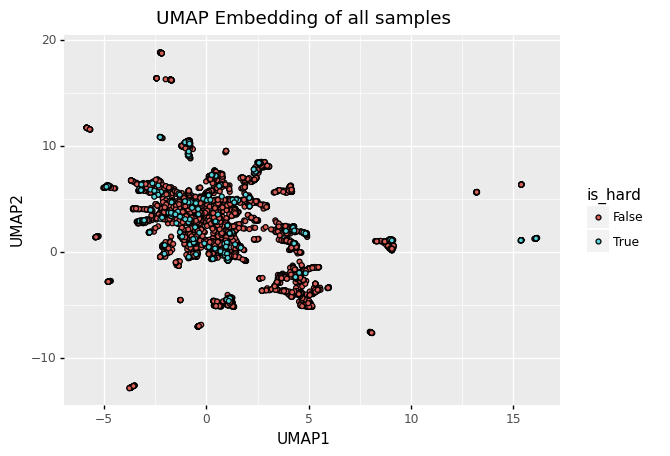

<ggplot: (8746109271153)>


In [126]:
plot = ggplot(umap_df, aes(x='UMAP1', y='UMAP2', fill='is_hard'))
plot += geom_point()
plot += ggtitle('UMAP Embedding of all samples')
print(plot)

## There seems to be a reasonable high-d linear dividing line since LR works well. Maybe PCA makes more sense for visualizing?

In [127]:
reducer = PCA(random_state=42, n_components=2)

In [128]:
%%time
expression_umap = reducer.fit_transform(expression_matrix)

CPU times: user 1.72 s, sys: 48 ms, total: 1.77 s
Wall time: 338 ms


In [129]:
pca_df = pd.DataFrame(expression_umap, index=sampled_df.index, columns=['UMAP1', 'UMAP2'])

In [130]:
pca_df['is_hard'] = is_hard

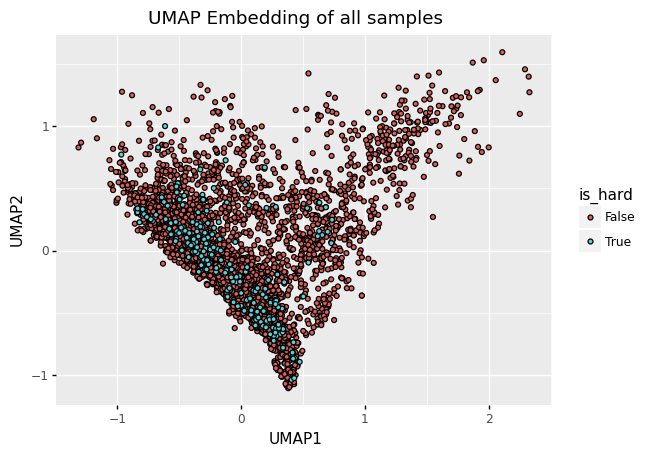

<ggplot: (8746109341033)>


In [131]:
plot = ggplot(pca_df, aes(x='UMAP1', y='UMAP2', fill='is_hard'))
plot += geom_point()
plot += ggtitle('UMAP Embedding of all samples')
print(plot)

## Do the hard samples stand out compared to other samples with the same label?

In [132]:
hard_sample_df['label'].value_counts()

Umbilical Cord    42
Heart             41
Blood             27
Brain             26
Epithelium        20
Breast            16
Stem Cell         13
Skin              13
Cervix             8
Kidney             8
Muscle             4
Blood Vessel       3
Lung               2
Colon              2
Testis             2
Spinal Cord        1
Liver              1
Bone Marrow        1
Name: label, dtype: int64

In [133]:
metadata_df['label'].value_counts()

Blood                  5179
Glioblastoma           1144
Breast                 1057
Lung                    803
Stem Cell               719
Brain                   702
Cervix                  686
Universal reference     599
Heart                   589
Kidney                  587
Brain reference         560
Large Intestine         534
SEQC_C                  484
SEQC_D                  483
Adipose Tissue          453
Skin                    446
Prostate                438
Umbilical Cord          287
Muscle                  276
Melanoma                243
Epithelium              218
Colon                   194
Pancreas                180
Tonsil                  171
Liver                   164
Bone Marrow             163
Placenta                157
Spinal Cord             145
Thymus                  116
Bone                     83
Bladder                  63
Blood Vessel             59
Airway                   52
Embryonic kidney         49
Testis                   46
Small Intestine     

The samples that are consistently mislabeled tend to be from the less common classes.

Potential causes:
1. There are fewer studies for those samples, so the inter-study differences are stronger (shouldn't be the case though since we're looking at an example with built-in leakage of study info between train and test sets)
2. There are fewer samples for the classes the hard samples are drawn from, so they are inherently harder predicton problems
3. Class imbalance causes these classes to consistently be predicted to be one of the more common classes (possibly in addition to the above)
4. Some samples may just be different from other samples in their class due to technical noise or vague labels

In [134]:
expression_df = expression_df.drop('is_hard', axis='columns')
is_hard = [sample in hard_samples for sample in metadata_df.index]
metadata_df['is_hard'] = is_hard

## Are the hard samples study-specific?

In [135]:
# Num samples per study
metadata_df[metadata_df['label'] == 'Umbilical Cord'].groupby('study').count()['is_hard']

study
SRP003754     2
SRP005281     1
SRP007461     2
SRP007508     3
SRP011085     1
SRP011378     3
SRP011927     3
SRP012167    25
SRP012695     3
SRP013984     2
SRP014213    13
SRP015761     1
SRP016059     1
SRP018020    16
SRP018234     2
SRP018403     4
SRP018778     1
SRP018815    12
SRP019222     1
SRP019240     1
SRP020556     3
SRP021214     6
SRP021524     4
SRP021912     2
SRP022054     4
SRP023233     2
SRP026333     3
SRP026690     5
SRP027015    12
SRP028301     6
SRP028822     1
SRP028902     5
SRP032812    20
SRP032922     1
SRP033491     8
SRP033711     2
SRP035268    10
SRP037718     6
SRP038101     6
SRP038759     2
SRP038761     1
SRP040694     4
SRP041255    22
SRP041820     2
SRP041825    24
SRP041846     5
SRP042184    24
Name: is_hard, dtype: int64

In [136]:
# Num hard samples per study
metadata_df[metadata_df['label'] == 'Umbilical Cord'].groupby('study').sum()['is_hard']

study
SRP003754    0.0
SRP005281    1.0
SRP007461    1.0
SRP007508    1.0
SRP011085    1.0
SRP011378    0.0
SRP011927    0.0
SRP012167    0.0
SRP012695    1.0
SRP013984    2.0
SRP014213    0.0
SRP015761    1.0
SRP016059    1.0
SRP018020    0.0
SRP018234    0.0
SRP018403    0.0
SRP018778    1.0
SRP018815    0.0
SRP019222    1.0
SRP019240    1.0
SRP020556    0.0
SRP021214    6.0
SRP021524    2.0
SRP021912    1.0
SRP022054    1.0
SRP023233    0.0
SRP026333    0.0
SRP026690    2.0
SRP027015    0.0
SRP028301    0.0
SRP028822    1.0
SRP028902    3.0
SRP032812    0.0
SRP032922    1.0
SRP033491    4.0
SRP033711    0.0
SRP035268    0.0
SRP037718    0.0
SRP038101    1.0
SRP038759    1.0
SRP038761    1.0
SRP040694    0.0
SRP041255    0.0
SRP041820    2.0
SRP041825    0.0
SRP041846    1.0
SRP042184    3.0
Name: is_hard, dtype: float64

In [165]:
metadata_df[(metadata_df['study'] == 'SRP033491') & (metadata_df['label'] == 'Umbilical Cord')]

,rail_id,study,sra.sample_acc.x,sra.experiment_acc,sra.submission_acc,sra.submission_center,sra.submission_lab,sra.study_title,sra.study_abstract,sra.study_description,...,recount_seq_qc.errq,recount_pred.sample_acc.y,recount_pred.curated.type,recount_pred.curated.tissue,recount_pred.pattern.predict.type,recount_pred.pred.type,recount_pred.curated.cell_type,recount_pred.curated.cell_line,label,is_hard
external_id,,,,,,,,,,,,,,,,,,,,,
SRR1042583,185871.0,SRP033491,SRS510685,SRX386749,SRA112073,BGI,BGI,China_type_2_diebetes_family,We sequenced the WGS/WGBS/Transcriptome/mircoR...,NaN,...,14.9,SRS510685,NaN,Umbilical Cord,rna-seq,rna-seq,NaN,NaN,Umbilical Cord,True
SRR1042584,185875.0,SRP033491,SRS510685,SRX386750,SRA112073,BGI,BGI,China_type_2_diebetes_family,We sequenced the WGS/WGBS/Transcriptome/mircoR...,NaN,...,14,SRS510685,NaN,Umbilical Cord,rna-seq,rna-seq,NaN,NaN,Umbilical Cord,False
SRR1042589,185894.0,SRP033491,SRS510687,SRX386753,SRA112073,BGI,BGI,China_type_2_diebetes_family,We sequenced the WGS/WGBS/Transcriptome/mircoR...,NaN,...,15,SRS510687,NaN,Umbilical Cord,rna-seq,rna-seq,NaN,NaN,Umbilical Cord,False
SRR1042591,185926.0,SRP033491,SRS510687,SRX386754,SRA112073,BGI,BGI,China_type_2_diebetes_family,We sequenced the WGS/WGBS/Transcriptome/mircoR...,NaN,...,15.2,SRS510687,NaN,Umbilical Cord,rna-seq,rna-seq,NaN,NaN,Umbilical Cord,False
SRR1042585,371756.0,SRP033491,SRS510685,SRX386750,SRA112073,BGI,BGI,China_type_2_diebetes_family,We sequenced the WGS/WGBS/Transcriptome/mircoR...,NaN,...,13.7,SRS510685,NaN,Umbilical Cord,rna-seq,rna-seq,NaN,NaN,Umbilical Cord,True
SRR1042586,371765.0,SRP033491,SRS510686,SRX386751,SRA112073,BGI,BGI,China_type_2_diebetes_family,We sequenced the WGS/WGBS/Transcriptome/mircoR...,NaN,...,15.6,SRS510686,NaN,Umbilical Cord,rna-seq,rna-seq,NaN,NaN,Umbilical Cord,True
SRR1042587,371773.0,SRP033491,SRS510686,SRX386752,SRA112073,BGI,BGI,China_type_2_diebetes_family,We sequenced the WGS/WGBS/Transcriptome/mircoR...,NaN,...,15.5,SRS510686,NaN,Umbilical Cord,rna-seq,rna-seq,NaN,NaN,Umbilical Cord,True
SRR1042588,371780.0,SRP033491,SRS510686,SRX386752,SRA112073,BGI,BGI,China_type_2_diebetes_family,We sequenced the WGS/WGBS/Transcriptome/mircoR...,NaN,...,15.8,SRS510686,NaN,Umbilical Cord,rna-seq,rna-seq,NaN,NaN,Umbilical Cord,False


### Manual inspection
It looks like there are lots of studies with hard samples and umbilical cord labels. A few stand out:

SRP021214 - 6 samples, 6 of which are consistently misclassified; all of which are HeLa cells not actual umbilical cord

SRP033491 - 8 samples, 4 of which are hard. It's hard to tell what tissue they're from based on the metadata, so the curation could be off. Also they all have really low errq (~15)


### Manual inspection
I looked at each of bone marrow studies to see if anything stood out:

| study | samples | hard samples | notes |
| ----- | ------  | ------------ | ----- |
DRP001219  |   1 | 0 | Child leukemia study |
DRP001220  |   1 | 0 | Child leukemia study (run by same group as above) |
ERP003613  |   8 | 3 | Healthy tissue; Swedish biobank |
SRP003754  |   2 | 0 | Actually pluripotent epithelial cells |
SRP005279  |  27 | 0 | Mixture of ALL (leukemuia) and healthy samples |
SRP007461  |   2 | 2 | ENCODE HMSC-bm (bone marrow) |
SRP007881  |   8 | 5 | Prostate cancer bone mestastases |
SRP009840  |  19 | 0 | Childhood ALL |
SRP015439  |   2 | 2 | Amniotic cells reprogrammed into endothelial cells |
SRP018028  |   3 | 3 | Healthy and RARS (leukemia precursor) patients' bone marrow |
SRP020556  |   8 | 1 | Leukemic Bone marrow |
SRP022025  |   3 |  1 | Leukemic blasts and promyelocytes |
SRP028554  |   4 | 4 | Leukemic bone marrow |
SRP028594  |  23 |20 | AML samples from bone marrow (half the samples in the study are blood though) |
SRP028912  |   8 | 7 | Lymphocyte cell lines |
SRP033266  |  14 | 8 | AML bone marrow |
SRP041036  |  30 | 0 | Bone marrow + chemo drugs |

## Do the hard samples show up on a UMAP?

In [138]:
expression_samples = set(expression_df.index)

marrow_df = metadata_df[metadata_df['label'] == 'Umbilical Cord']
marrow_samples = [sample for sample in marrow_df.index if sample in expression_samples]

marrow_expression = expression_df.loc[marrow_samples]

marrow_expression

,ENSG00000253132.1,ENSG00000172465.13,ENSG00000206013.2,ENSG00000214866.8,ENSG00000270390.1,ENSG00000235447.2,ENSG00000108602.17,ENSG00000279997.1,ENSG00000267112.1,ENSG00000234670.1,...,ENSG00000242960.1,ENSG00000274029.1,ENSG00000201945.1,ENSG00000121440.14,ENSG00000229616.2,ENSG00000088992.17,ENSG00000240964.3,ENSG00000111906.17,ENSG00000128596.16,ENSG00000255575.1
sample,,,,,,,,,,,,,,,,,,,,,
SRR1027737,0.000000,0.0,0.003368,0.017899,0.001104,0.000000,0.000000,0.006233,0.006622,0.000359,...,0.001562,0.000000,0.017899,0.000007,0.000140,0.119751,0.0,0.002138,0.019669,0.0
SRR1027739,0.000000,0.0,0.005093,0.016281,0.000986,0.000000,0.000000,0.013794,0.005833,0.000712,...,0.001500,0.000000,0.047455,0.000140,0.000008,0.185791,0.0,0.001568,0.019577,0.0
SRR1027728,0.000015,0.0,0.002987,0.027191,0.002890,0.000000,0.000088,0.015022,0.006485,0.000786,...,0.000622,0.000000,0.035706,0.000009,0.000035,0.115784,0.0,0.001219,0.019882,0.0
SRR1027729,0.000000,0.0,0.002897,0.028091,0.002169,0.000000,0.000025,0.013939,0.006107,0.000661,...,0.000690,0.000002,0.034454,0.000025,0.000032,0.116882,0.0,0.000918,0.019989,0.0
SRR1027730,0.000000,0.0,0.002645,0.029633,0.002905,0.000000,0.000030,0.012352,0.006725,0.000396,...,0.000743,0.000000,0.033142,0.000008,0.000031,0.115112,0.0,0.001159,0.018707,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SRR1248271,0.000000,0.0,0.038483,0.010849,0.006531,0.000044,0.000000,0.024902,0.000758,0.000930,...,0.058929,0.000000,0.185425,0.000000,0.000034,0.048645,0.0,0.003183,0.033844,0.0
SRR1248272,0.000000,0.0,0.038513,0.011398,0.007069,0.000031,0.000000,0.023102,0.000648,0.000941,...,0.058350,0.000000,0.182983,0.000000,0.000046,0.047882,0.0,0.003330,0.032623,0.0
SRR1248273,0.000000,0.0,0.038300,0.011566,0.007202,0.000052,0.000000,0.024765,0.000587,0.001021,...,0.057983,0.000000,0.185059,0.000000,0.000045,0.048523,0.0,0.002901,0.034088,0.0


In [139]:
expression_matrix = marrow_expression.to_numpy()

In [140]:
reducer = umap.UMAP(transform_seed=42, random_state=42, n_components=2)
marrow_umap = reducer.fit_transform(expression_matrix)

In [141]:
umap_df = pd.DataFrame(marrow_umap, columns=['UMAP1', 'UMAP2'], index=marrow_expression.index)
umap_df

,UMAP1,UMAP2
sample,,
SRR1027737,5.530167,2.174903
SRR1027739,5.305780,0.584914
SRR1027728,5.398022,1.766108
SRR1027729,5.494351,1.841952
SRR1027730,5.441812,1.771977
...,...,...
SRR1248271,10.458704,9.082756
SRR1248272,10.485508,8.939318
SRR1248273,10.508144,9.075282


In [142]:
is_hard = [sample in hard_samples for sample in umap_df.index]
umap_df['is_hard'] = is_hard
umap_df['study'] = metadata_df.loc[umap_df.index]['study']
umap_df['platform'] = metadata_df.loc[umap_df.index]['sra.platform_model']
umap_df['date'] = metadata_df.loc[umap_df.index]['sra.run_published']


umap_df

,UMAP1,UMAP2,is_hard,study,platform,date
sample,,,,,,
SRR1027737,5.530167,2.174903,False,SRP032812,Illumina HiSeq 2000,2013-11-14 08:34:14
SRR1027739,5.305780,0.584914,False,SRP032812,Illumina HiSeq 2000,2013-11-14 08:34:14
SRR1027728,5.398022,1.766108,False,SRP032812,Illumina HiSeq 2000,2013-11-14 08:34:14
SRR1027729,5.494351,1.841952,False,SRP032812,Illumina HiSeq 2000,2013-11-14 08:34:14
SRR1027730,5.441812,1.771977,False,SRP032812,Illumina HiSeq 2000,2013-11-14 08:34:14
...,...,...,...,...,...,...
SRR1248271,10.458704,9.082756,False,SRP041255,Illumina HiSeq 2000,2014-07-28 15:08:56
SRR1248272,10.485508,8.939318,False,SRP041255,Illumina HiSeq 2000,2014-07-28 15:08:56
SRR1248273,10.508144,9.075282,False,SRP041255,Illumina HiSeq 2000,2014-07-28 15:08:56


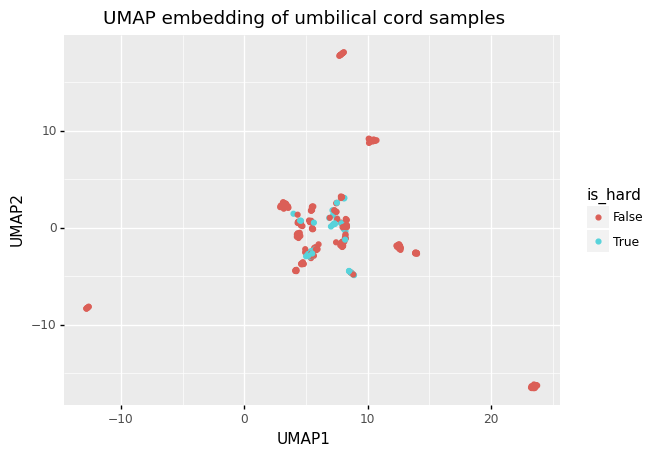

<ggplot: (8746086171701)>


In [143]:
plot = ggplot(umap_df, aes(x='UMAP1', y='UMAP2', color='is_hard'))
plot += geom_point()
plot += ggtitle('UMAP embedding of umbilical cord samples')
print(plot)

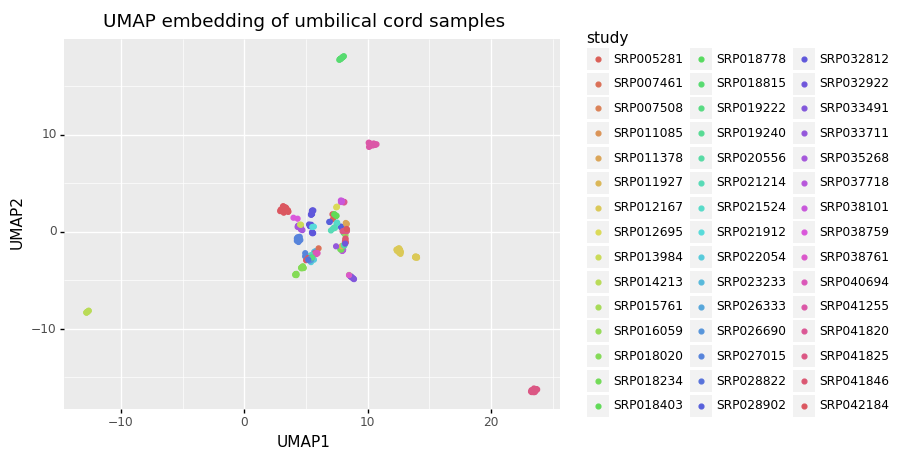

<ggplot: (8746086353121)>


In [144]:
plot = ggplot(umap_df, aes(x='UMAP1', y='UMAP2', color='study'))
plot += geom_point()
plot += ggtitle('UMAP embedding of umbilical cord samples')
print(plot)

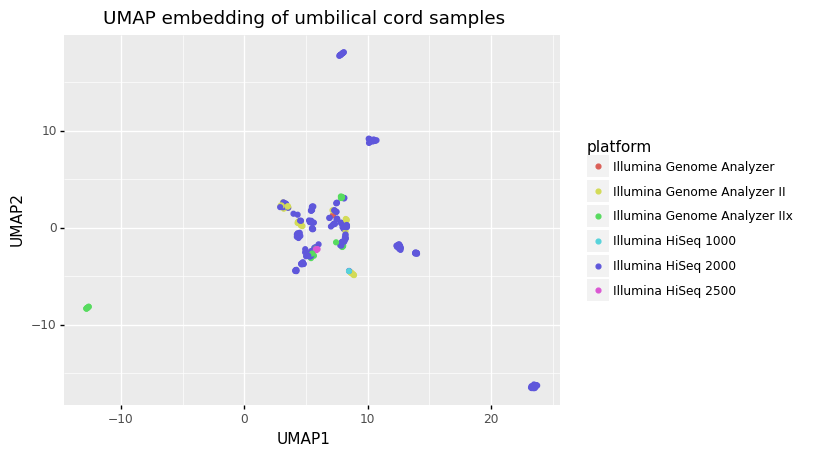

<ggplot: (8746087842229)>


In [145]:
plot = ggplot(umap_df, aes(x='UMAP1', y='UMAP2', color='platform'))
plot += geom_point()
plot += ggtitle('UMAP embedding of umbilical cord samples')
print(plot)

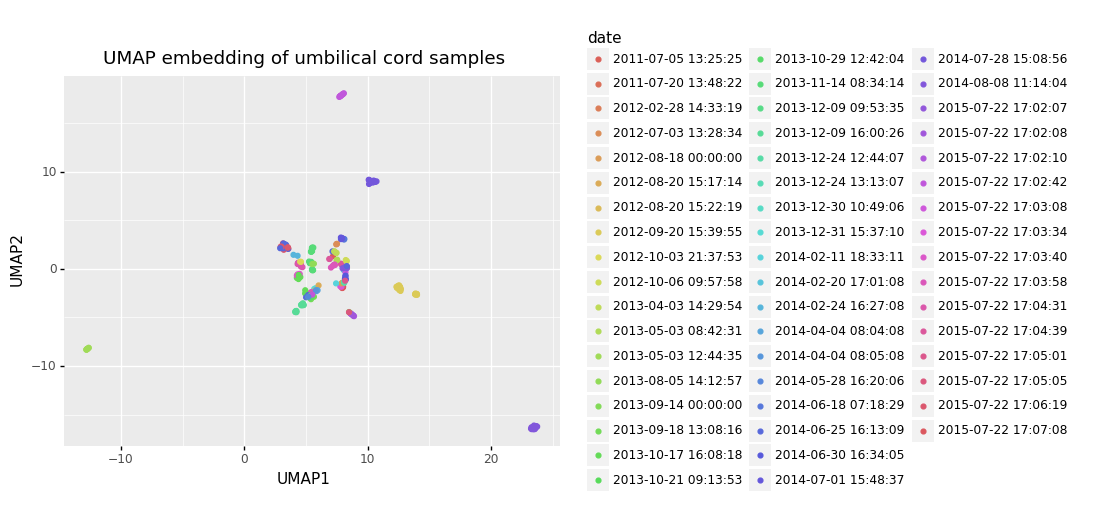

<ggplot: (8746087842213)>


In [146]:
plot = ggplot(umap_df, aes(x='UMAP1', y='UMAP2', color='date'))
plot += geom_point()
plot += ggtitle('UMAP embedding of umbilical cord samples')
print(plot)

### PCA?

In [147]:
reducer =PCA(random_state=42, n_components=2)
marrow_umap = reducer.fit_transform(expression_matrix)

In [148]:
umap_df = pd.DataFrame(marrow_umap, columns=['PC1', 'PC2'], index=marrow_expression.index)
umap_df

,PC1,PC2
sample,,
SRR1027737,0.444538,0.147484
SRR1027739,0.052572,0.273374
SRR1027728,0.177370,0.287846
SRR1027729,0.176904,0.286432
SRR1027730,0.190546,0.297098
...,...,...
SRR1248271,-0.822187,-0.682431
SRR1248272,-0.824017,-0.682608
SRR1248273,-0.822561,-0.682567


In [149]:
is_hard = [sample in hard_samples for sample in umap_df.index]
umap_df['is_hard'] = is_hard
umap_df['study'] = metadata_df.loc[umap_df.index]['study']
umap_df['platform'] = metadata_df.loc[umap_df.index]['sra.platform_model']
umap_df['date'] = metadata_df.loc[umap_df.index]['sra.run_published']


umap_df

,PC1,PC2,is_hard,study,platform,date
sample,,,,,,
SRR1027737,0.444538,0.147484,False,SRP032812,Illumina HiSeq 2000,2013-11-14 08:34:14
SRR1027739,0.052572,0.273374,False,SRP032812,Illumina HiSeq 2000,2013-11-14 08:34:14
SRR1027728,0.177370,0.287846,False,SRP032812,Illumina HiSeq 2000,2013-11-14 08:34:14
SRR1027729,0.176904,0.286432,False,SRP032812,Illumina HiSeq 2000,2013-11-14 08:34:14
SRR1027730,0.190546,0.297098,False,SRP032812,Illumina HiSeq 2000,2013-11-14 08:34:14
...,...,...,...,...,...,...
SRR1248271,-0.822187,-0.682431,False,SRP041255,Illumina HiSeq 2000,2014-07-28 15:08:56
SRR1248272,-0.824017,-0.682608,False,SRP041255,Illumina HiSeq 2000,2014-07-28 15:08:56
SRR1248273,-0.822561,-0.682567,False,SRP041255,Illumina HiSeq 2000,2014-07-28 15:08:56


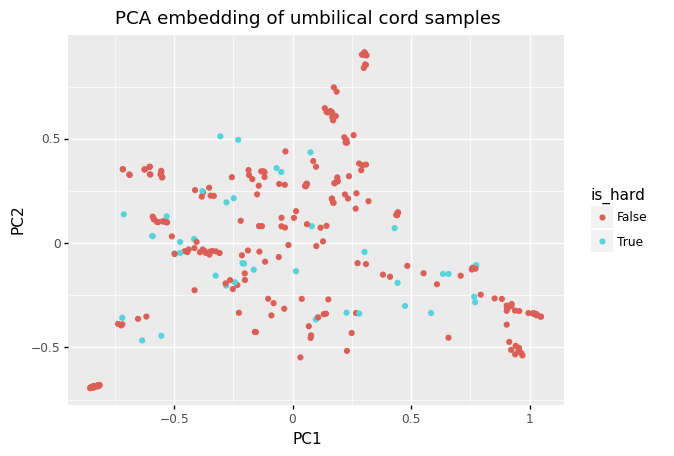

<ggplot: (8746088018377)>


In [150]:
plot = ggplot(umap_df, aes(x='PC1', y='PC2', color='is_hard'))
plot += geom_point()
plot += ggtitle('PCA embedding of umbilical cord samples')
print(plot)

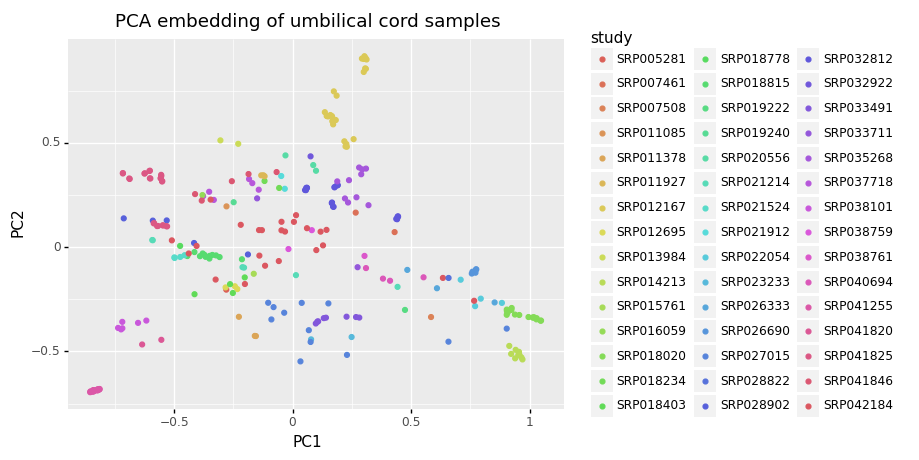

<ggplot: (8746109340093)>


In [151]:
plot = ggplot(umap_df, aes(x='PC1', y='PC2', color='study'))
plot += geom_point()
plot += ggtitle('PCA embedding of umbilical cord samples')
print(plot)

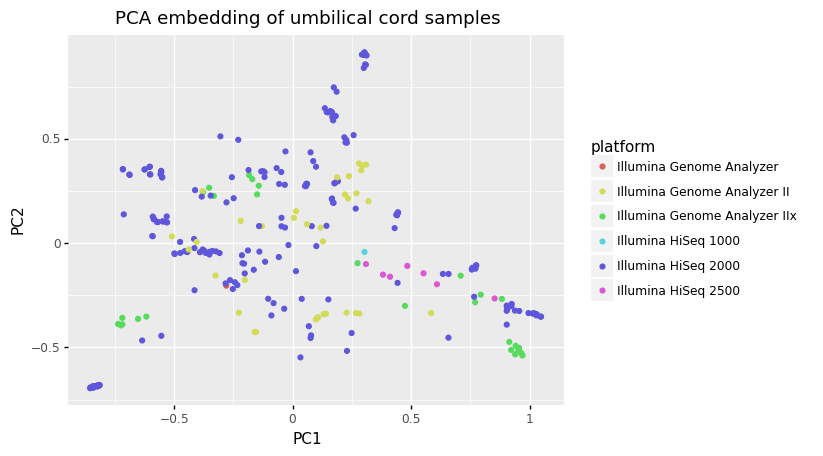

<ggplot: (8745921773269)>


In [152]:
plot = ggplot(umap_df, aes(x='PC1', y='PC2', color='platform'))
plot += geom_point()
plot += ggtitle('PCA embedding of umbilical cord samples')
print(plot)

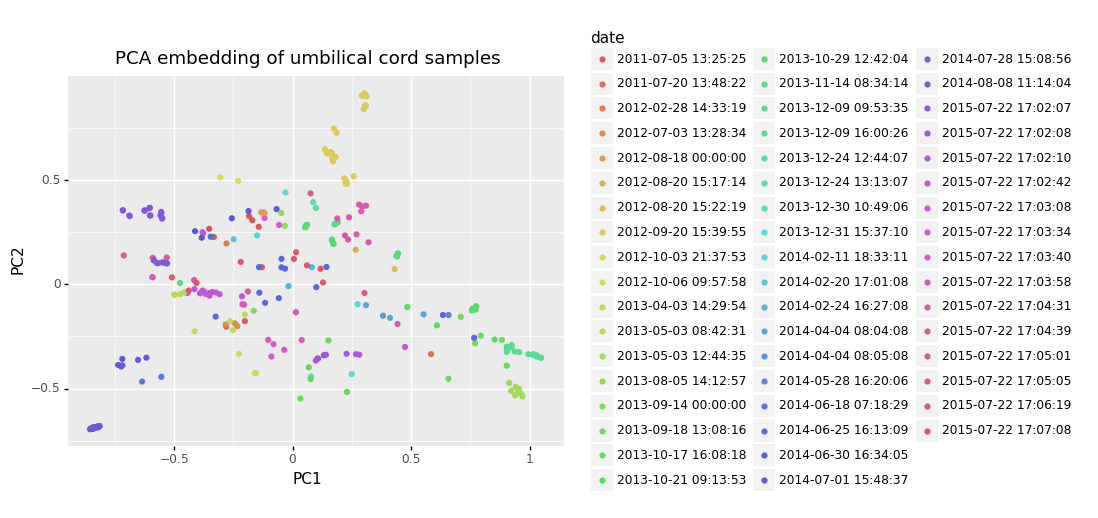

<ggplot: (8746086429049)>


In [153]:
plot = ggplot(umap_df, aes(x='PC1', y='PC2', color='date'))
plot += geom_point()
plot += ggtitle('PCA embedding of umbilical cord samples')
print(plot)

## Sequencer?
There doesn't seem an expression difference that causes all the bad samples to cluster together, but there does seem to be a disproportionate amount of hard to classify samples from the HiSeq 2000. Does this hold in general/in other tissue types?

In [154]:
hard_df = metadata_df[metadata_df['is_hard']]

In [155]:
hard_df['sra.platform_model'].value_counts()

Illumina HiSeq 2000             150
Illumina Genome Analyzer IIx     38
Illumina Genome Analyzer II      30
Illumina Genome Analyzer          6
Illumina HiSeq 2500               4
Illumina HiSeq 1000               2
Name: sra.platform_model, dtype: int64

In [156]:
hard_df['sra.platform_model'].value_counts() / len(hard_df)

Illumina HiSeq 2000             0.652174
Illumina Genome Analyzer IIx    0.165217
Illumina Genome Analyzer II     0.130435
Illumina Genome Analyzer        0.026087
Illumina HiSeq 2500             0.017391
Illumina HiSeq 1000             0.008696
Name: sra.platform_model, dtype: float64

In [157]:
metadata_df['sra.platform_model'].value_counts() / len(metadata_df)

Illumina HiSeq 2500                                                                                                                                                  0.352234
Illumina HiSeq 2000                                                                                                                                                  0.291082
NextSeq 500                                                                                                                                                          0.165259
Illumina HiSeq 4000                                                                                                                                                  0.089679
Illumina HiSeq 3000                                                                                                                                                  0.017089
Illumina Genome Analyzer IIx                                                                                                      

### Sequencer Results

There seems to be a marked increase in hard-to-classify Hi-seq 2000 samples and decrease in Hi-seq 2500 samples. Is there a reason for this?


In [158]:
hard_studies = set(hard_df['study'])
hard_study_df = metadata_df[metadata_df['study'].isin(hard_studies)]

In [159]:
hard_study_df['sra.platform_model'].value_counts() 

Illumina HiSeq 2000             1484
Illumina Genome Analyzer II      341
Illumina Genome Analyzer IIx     128
Illumina HiSeq 2500               56
Illumina Genome Analyzer          25
Illumina HiSeq 1000                4
Name: sra.platform_model, dtype: int64

In [160]:
hard_study_df['sra.platform_model'].value_counts() / len(hard_study_df)

Illumina HiSeq 2000             0.728165
Illumina Genome Analyzer II     0.167321
Illumina Genome Analyzer IIx    0.062807
Illumina HiSeq 2500             0.027478
Illumina Genome Analyzer        0.012267
Illumina HiSeq 1000             0.001963
Name: sra.platform_model, dtype: float64

### More sequencer results
The enrichment for Hi-seq 2000 may just be because the studies with hard samples are themselves enriched for Hi-seq 2000. 
The sequencer probably may not be meaningful, but this is still interesting. It feels like the samples are drawn at random from the studies, yielding the given distribution.

Unclear whether this is true though, the studies themselves seem to to be heavily skewed.

## Remaining questions:
- Is it related to sparsity?
- Is there something correlated with sequencer that we'd expect to cause these results?
- Stuff below

## Error analysis on hard samples

In [161]:
sample_model_predictions = {}
model_predictions = {}
# Process dataframe rows
for i, row in tissue_metrics[tissue_metrics['is_pretrained'] == 'not_pretrained'].iterrows():
    model = row['supervised']
    
    if model not in model_predictions:
        model_predictions[model] = {'predicted': [], 'true': [], 'sample': []}
    
    encoder_string = row['val_encoders']
    encoder = json.loads(encoder_string)
    decoder = {number: label for label, number in encoder.items()}
    
    samples = row['val samples'].strip().split(',')
    
    predictions = row['val_predictions'].strip().split(',')
    truth = row['val_true_labels'].strip().split(',')
    pred_labels = []
    true_labels = []

    for prediction, true_label, sample in zip(predictions, truth, samples):
        
        if sample not in hard_samples:
            continue
        
        if int(prediction) in decoder:
            pred_labels.append(decoder[int(prediction)])
        else:
            # https://github.com/greenelab/saged/issues/58
            pred_labels.append('invalid_index')
            
        true_labels.append(decoder[int(true_label)])
               
    predictions = pred_labels
    truth = true_labels
        
    assert len(truth) == len(predictions)
    
    model_predictions[model]['predicted'].extend(predictions)
    model_predictions[model]['true'].extend(truth)
    model_predictions[model]['sample'].extend(samples)

In [162]:
confusion_df = create_confusion_df(model_predictions)

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide


In [163]:
melted_df = confusion_df.melt(id_vars='true_tissue', var_name='pred_tissue')
melted_df['log_value'] = np.log(melted_df['value'])
melted_df['percent'] = (melted_df['value'] * 100).round(1)

/home/heil/anaconda3/envs/saged/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log


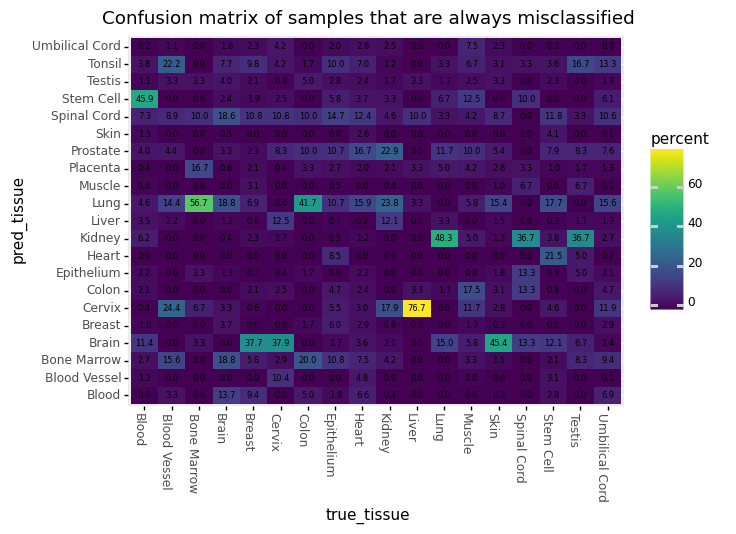

<ggplot: (8746087412961)>

In [164]:
plot = ggplot(melted_df, aes(x='true_tissue', y='pred_tissue', fill='percent',)) 
plot += geom_tile() 
plot += geom_text(aes(label='percent'), size=6)
plot += theme(axis_text_x=element_text(rotation=270, hjust=1))
plot += ggtitle('Confusion matrix of samples that are always misclassified')
plot

## Conclusion (for now)
So far, my best lead on the issue is that it's a class imbalance problem and I need to make the loss function weight infrequent classes more heavily. Also, some classes just look a lot like other classes (especially bone marrow/blood).

### A few remaining questions:
- What is the correlation in errors between different runs of the same model?
- Are these correlations affected by the amount of data used?